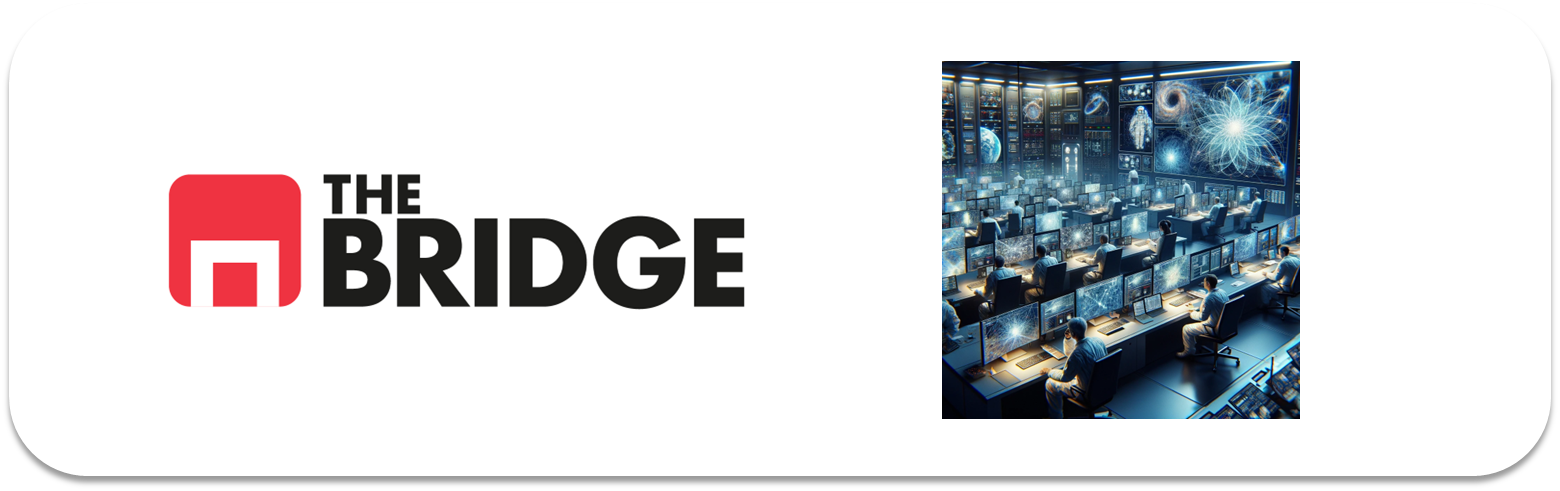

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [254]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import re

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import MaxPool2D, Dropout, Flatten, Dense, Conv2D
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical


### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.


In [255]:
ROOT_PATH = './data/'
TRAIN_PATH = ['github_train_0/', 'github_train_1/', 'github_train_2/', 'github_train_3/']
TEST_PATH = "github_test/"

def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    
    for file in os.listdir(directorio):

        image = cv2.imread('/'.join([directorio, file]))
        image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

        X.append(image)
        y.append(re.findall('cat|dog', file)[0])

    return np.array(X), np.array(y)

In [256]:
# el test

x_test, y_test = read_data(ROOT_PATH + TEST_PATH)

In [257]:
y_test.shape

(1000,)

In [258]:
# el train

x_train = [read_data(ROOT_PATH + i)[0] for i in TRAIN_PATH] # iteramos la funcion por los directorios y guardamos los arrays en una lista
x_train = np.vstack(x_train) # concatenamos verticalmente los arrays, vertical xq son 32x32x3, en horizontal se concatenan erroneamente

y_train = [read_data(ROOT_PATH + i)[1] for i in TRAIN_PATH] # igual con el test
y_train = np.hstack(y_train) # aqui concatenamos horizontal xq son de 1 dim

In [259]:
x_train.shape

(4000, 32, 32, 3)

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

<Axes: >

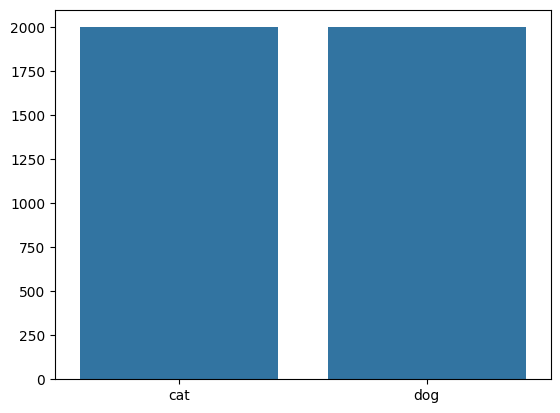

In [260]:
# minieda del target

dict_valores = dict()
for i in y_train:
    if i not in dict_valores.keys():
        dict_valores[i] = 1
    else:
        dict_valores[i] += 1

sns.barplot(dict_valores)
# que equilibrado!!!

In [261]:
# voy a pasar los targets a numericos

y_train_map = np.array(list(map(lambda x: 0 if x == 'cat' else 1, y_train)))
y_test_map = np.array(list(map(lambda x: 0 if x == 'cat' else 1, y_test)))


In [262]:
y_train_map

array([0, 0, 0, ..., 1, 1, 1])

In [263]:
# escalamos

x_train = x_train/255
x_test = x_test/255

In [264]:
# empiezo a crear el modelo

model_dl = Sequential()

model_dl.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,3)))

model_dl.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))

model_dl.add(Dropout(rate= 0.25)) # dropout

model_dl.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model_dl.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model_dl.add(Dropout(0.25)) # dropout

# empezamos con el modelo de dl propiamente dicho una vez establecidas las 2 capas de convalidation

model_dl.add(Flatten())

model_dl.add(Dense(256, activation = "relu"))

model_dl.add(Dropout(0.5))

model_dl.add(Dense(2, activation = "softmax"))

In [265]:
print(x_train.size) # mas de un millon, voy a optimizar con Adam
optimizer = Adam()

12288000


In [266]:
model_dl.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"]) 

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

In [267]:
# voy a poner estos parametros siguiendo el modelo del workout, sin mas

batch_size = 128
epochs = 20
validation_split = 0.2

history = model_dl.fit(x_train, y_train_map, batch_size = batch_size, epochs= epochs, validation_split= validation_split)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5699 - loss: 0.7570 - val_accuracy: 0.0000e+00 - val_loss: 0.8281
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6230 - loss: 0.6601 - val_accuracy: 0.0050 - val_loss: 0.7886
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6255 - loss: 0.6547 - val_accuracy: 0.3638 - val_loss: 0.7135
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6312 - loss: 0.6473 - val_accuracy: 0.1388 - val_loss: 0.7829
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6437 - loss: 0.6283 - val_accuracy: 0.1575 - val_loss: 0.8708
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6610 - loss: 0.6185 - val_accuracy: 0.7962 - val_loss: 0.5851
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6639 - loss: 0.6053 - val_accuracy: 0.8763 - val_loss: 0.5031
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6623 - loss: 0.6169 - val_accuracy: 0.2725

In [268]:
history_df = pd.DataFrame(history.history)
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.590312,0.708471,0.00000,0.828083
1,0.622500,0.660962,0.00500,0.788643
2,0.630938,0.655575,0.36375,0.713464
3,0.630000,0.643591,0.13875,0.782916
4,0.647500,0.628666,0.15750,0.870824
5,0.659375,0.615396,0.79625,0.585121
6,0.667188,0.607253,0.87625,0.503082
7,0.675000,0.602136,0.27250,0.864720
8,0.678750,0.600832,0.74625,0.600271
9,0.696250,0.579589,0.60000,0.685467


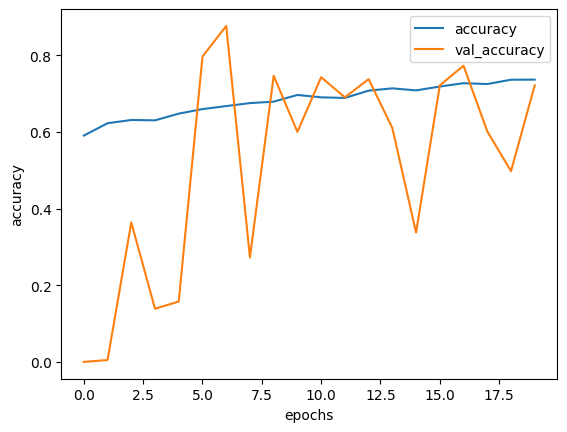

In [269]:
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

# esas idas y venidas en el validacion son normales?

In [270]:
model_dl.evaluate(x_test,y_test_map)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6821 - loss: 0.5748


[0.5759052634239197, 0.6859999895095825]

In [271]:
y_pred = [np.argmax(prediction) for prediction in  model_dl.predict(x_test)]

print(classification_report(y_test_map,y_pred))



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       500
           1       0.68      0.71      0.69       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.

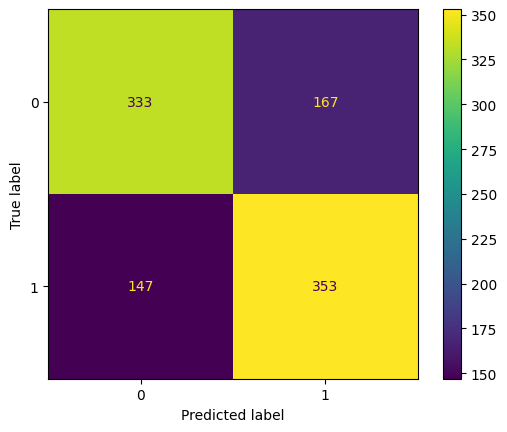

In [272]:
ConfusionMatrixDisplay.from_predictions(y_test_map, y_pred)

'''
0: cat
1: dog
'''

In [291]:
# mi idea es crear una lista donde almaceno los indices de los errores, para eso primero zipeo las predicciones con los valores reales y si esos valores son diferentes, agrego su indice (orden) a la lista de errores

pred_vs_true = zip(y_pred, y_test_map)

lista_errores = list()

for index, images in enumerate(pred_vs_true):
    
    if images[0] != images[1]:
        lista_errores.append(index)

print(len(lista_errores))

314


In [294]:
# aqui la idea es generar otra lista donde almacenos unicamente el 10% de los errores elegidos al azar, recuerdo que almaceno los indices

import random

xciento = int(len(lista_errores)/10) # 10%
lista_decima_parte = random.sample(lista_errores, xciento) # vamos a coger una decima parte al azar utilizando sample del modulo random

In [323]:
# a continuacion voy a printear unos subplots con las imagenes que se han clasificado erroneamente, para iterar sobre los subplots de la figura necesitare el indice del subplot de turno,
# para iterarlo de forma simple voy a crear un generador e instanciar un indice que vaya pasandose automaticamente

def generador_indices():
    for line in range(7):
        for col in range(5):
            yield line, col

indice = generador_indices()

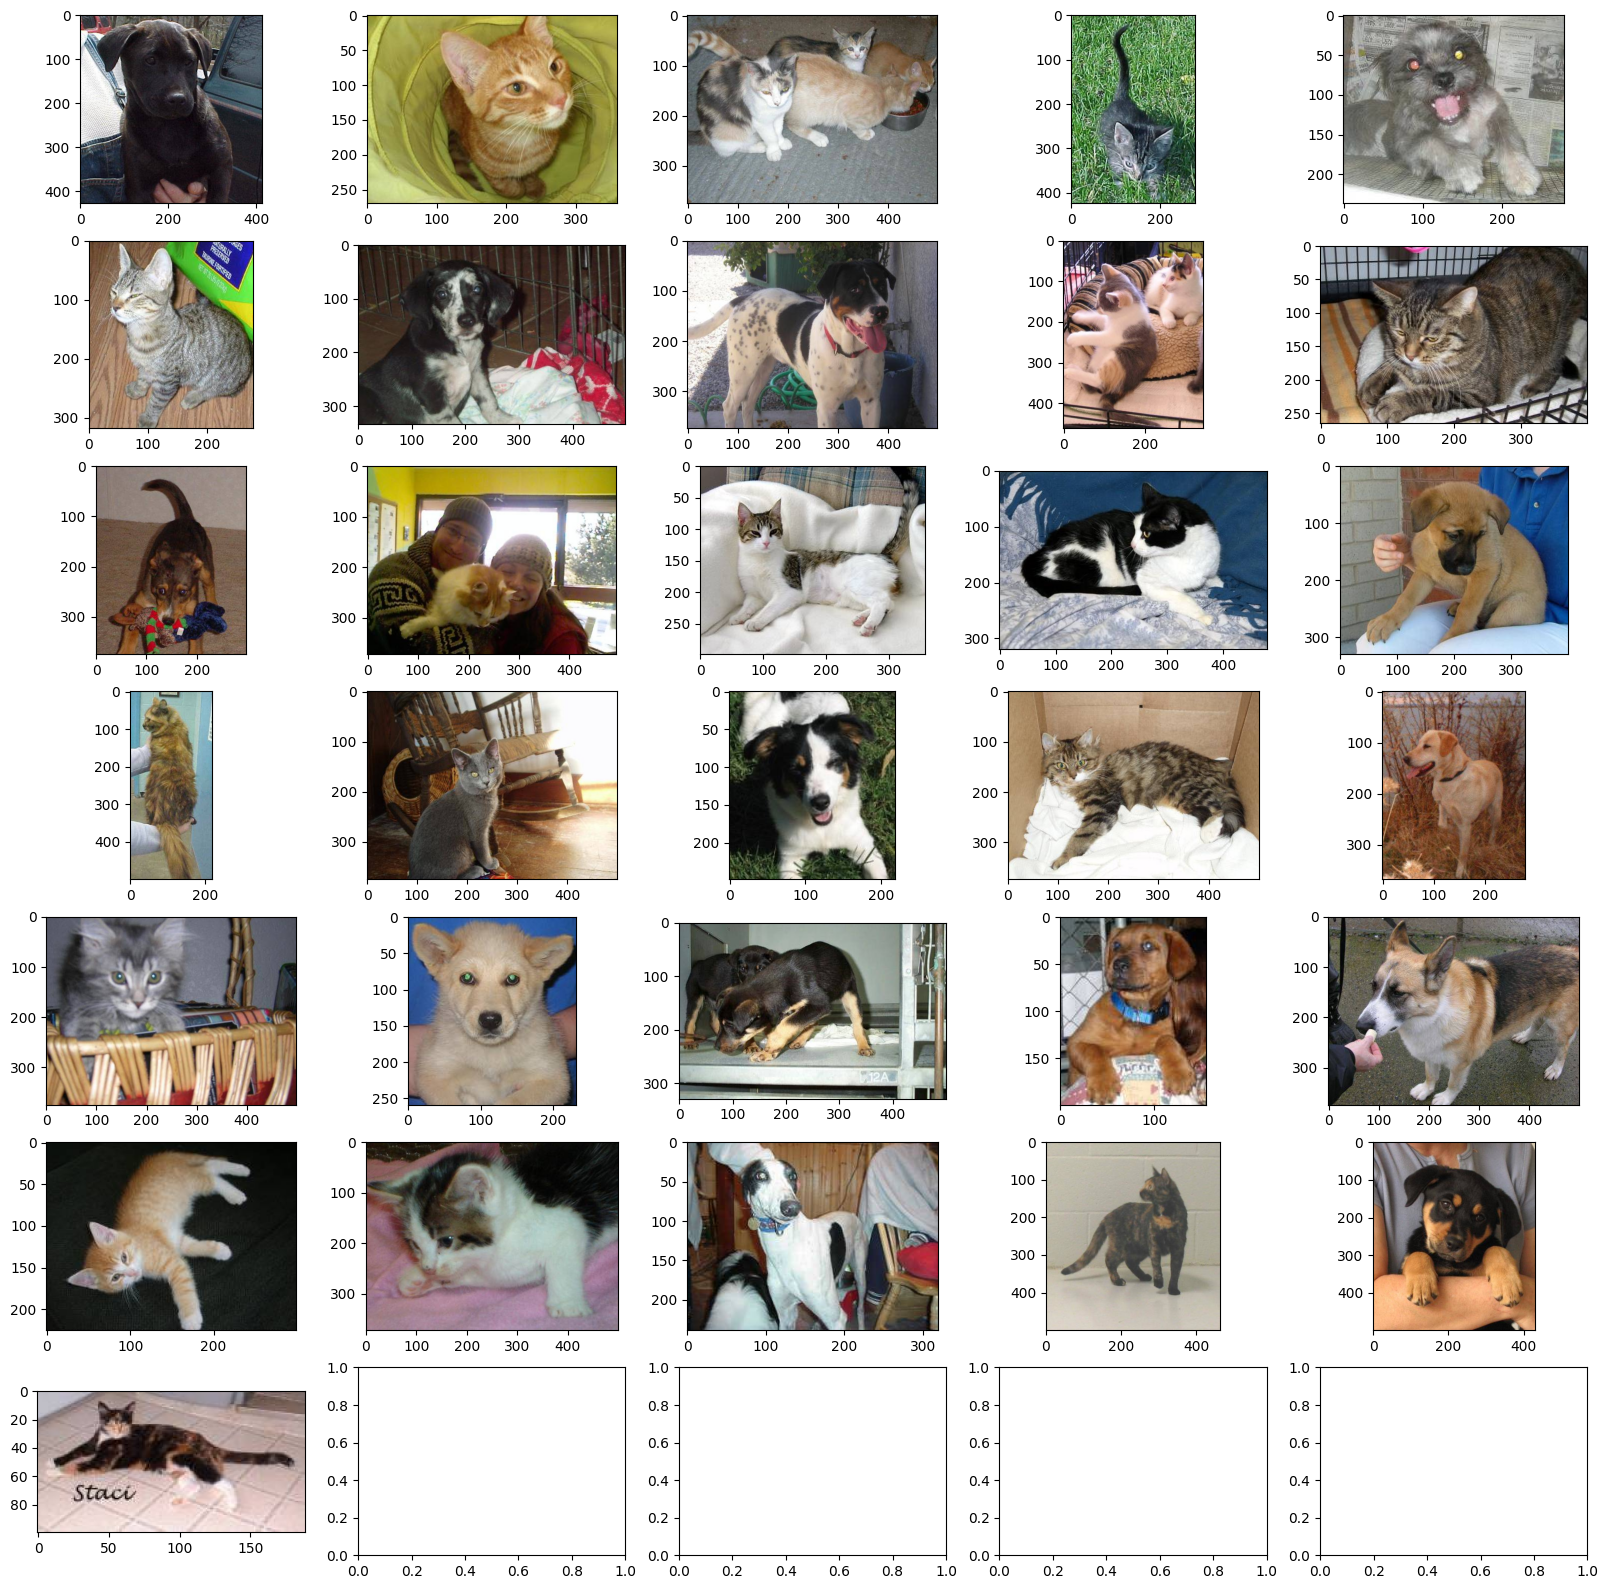

In [324]:
import matplotlib.image as mpimg # con este modulo puedo printear imagenes, concepto nuevo

fig, axs = plt.subplots(7, 5, figsize= (20, 20)) # creo la figura y sus subplots, para 31 imagenes valdra con una shape de 7x5

images = list() # aqui almacenare los titulos del archivo/imagen
for image in os.listdir('./data/github_test/'): # itero los archivos del data para test y añado estos archivos(titulo.jpeg) a la lista de imagenes
    images.append(image)

for index in lista_decima_parte: # itero sobre las imagenes clasificadas erroneamente
    image_path = f'./data/github_test/{images[index]}' # defino el path del archivo/imagen clasificado erroneamente
    image = mpimg.imread(image_path) # convierto a array el archivo .jpeg
    axs[next(indice)].imshow(image) # lo muestro en el subplot que corresponde

# aqui tenemos 31 de las imagenes mal clasificadas, esta parte me sirvio para aprender a manejar mping, asi que guay
    